In [41]:
# Group 2: Wholesale Customers Clustering (K-means vs DBSCAN)

In [42]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from scipy.stats import kruskal, chi2_contingency
sns.set(style='whitegrid')


In [43]:
# Part A: Data Loading & Preprocessing
# CSV path
file_path = r"C:\Users\HP G3\Desktop\Artificial-Intelligence\GROUP 2 (ASSIGNMENT 3)\Wholesale customers data.csv"

df = pd.read_csv(file_path)
print('Initial shape:', df.shape)
print(df.dtypes)

Initial shape: (440, 8)
Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object


In [44]:
# Handle missing & duplicates
df = df.fillna(df.median(numeric_only=True)).drop_duplicates()
print('Shape after cleaning:', df.shape)

Shape after cleaning: (440, 8)


In [45]:
# Scale numeric features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df[num_cols])

In [46]:
# Handle missing & duplicates
df = df.fillna(df.median()).drop_duplicates()
print('Shape after cleaning:', df.shape)

Shape after cleaning: (440, 8)


In [47]:
# Scale numeric features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df[num_cols])

          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
50%      1.000000    3.000000    8504.000000   3627.000000   4755.500000   
75%      2.000000    3.000000   16933.750000   7190.250000  10655.750000   
max      2.000000    3.000000  112151.000000  73498.000000  92780.000000   

             Frozen  Detergents_Paper    Delicassen  
count    440.000000        440.000000    440.000000  
mean    3071.931818       2881.493182   1524.870455  
std     4854.673333       4767.854448   2820.105937  
min       25.000000          3.000000      3.000000  
25%      742.250000        256.750000    408.

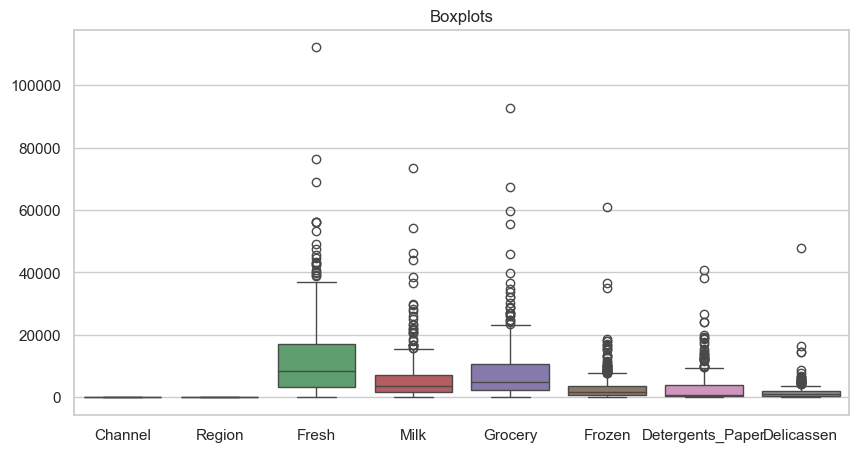

In [48]:
# Part B: First EDA
print(df[num_cols].describe())
plt.figure(figsize=(10,5)); sns.boxplot(data=df[num_cols]); plt.title('Boxplots'); plt.show()

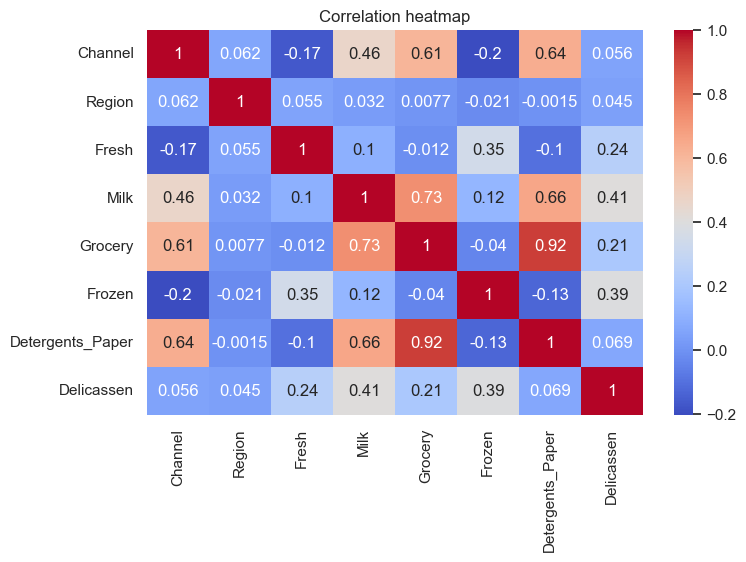

In [49]:
# Log-transform skewed vars
skewed = df[num_cols].skew().abs() > 1
df_log = df.copy()
for c in df.columns[skewed]: df_log[c] = np.log1p(df[c])

plt.figure(figsize=(8,5))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()

In [50]:
# Part C: Feature Engineering
df['TotalSpend'] = df[num_cols].sum(axis=1)
df['ProportionFresh'] = df['Fresh']/df['TotalSpend']
df['LogTotalSpend'] = np.log1p(df['TotalSpend'])

In [51]:
# Part D: Clustering Modelling
X = df[num_cols].apply(np.log1p)
X['LogTotalSpend'] = df['LogTotalSpend']
X['ProportionFresh'] = df['ProportionFresh'].fillna(0)
X_scaled = RobustScaler().fit_transform(X)

In [52]:
# K-means (k=2..8)
res=[]
for k in range(2,9):
    km=KMeans(n_clusters=k,random_state=0,n_init=10)
    lab=km.fit_predict(X_scaled)
    res.append((k,silhouette_score(X_scaled,lab),davies_bouldin_score(X_scaled,lab)))
km_df=pd.DataFrame(res,columns=['k','Silhouette','DB_index'])
print(km_df)

best_k=int(km_df.sort_values(['Silhouette','DB_index'],ascending=[False,True]).iloc[0]['k'])
km_final=KMeans(n_clusters=best_k,random_state=0,n_init=20).fit(X_scaled)
k_labels=km_final.labels_

   k  Silhouette  DB_index
0  2    0.221620  1.697022
1  3    0.178425  1.660659
2  4    0.222002  1.415222
3  5    0.197953  1.487374
4  6    0.203573  1.468774
5  7    0.213708  1.402032
6  8    0.203049  1.425207


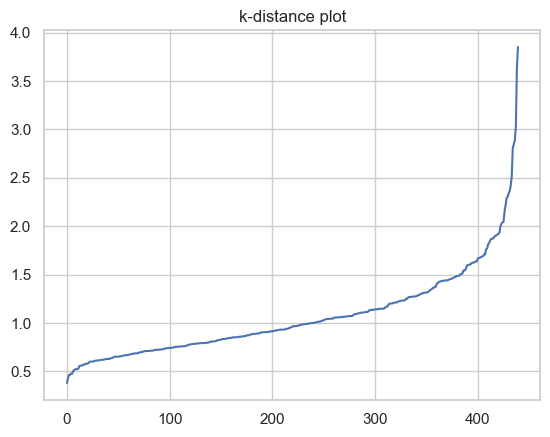

K-means clusters: (array([0, 1, 2, 3]), array([123,  70, 183,  64], dtype=int64))
DBSCAN clusters: (array([-1,  0,  1,  2], dtype=int64), array([409,  16,   9,   6], dtype=int64))


In [53]:
# DBSCAN
nbrs=NearestNeighbors(n_neighbors=4).fit(X_scaled)
distances=np.sort(nbrs.kneighbors(X_scaled)[0][:,3])
plt.plot(distances);plt.title('k-distance plot');plt.show()

db=DBSCAN(eps=0.6,min_samples=5).fit(X_scaled)
db_labels=db.labels_

print('K-means clusters:',np.unique(k_labels,return_counts=True))
print('DBSCAN clusters:',np.unique(db_labels,return_counts=True))

In [54]:
# Part E: Statistical Inference
df['kmeans_cluster']=k_labels; df['dbscan_cluster']=db_labels


In [55]:
# Kruskal-Wallis for TotalSpend
groups=[g['TotalSpend'].values for _,g in df.groupby('kmeans_cluster')]
print('Kruskal-Wallis (K-means):',kruskal(*groups))

groups_db=[g['TotalSpend'].values for l,g in df.groupby('dbscan_cluster') if l!=-1]
if len(groups_db)>1: print('Kruskal-Wallis (DBSCAN):',kruskal(*groups_db))

Kruskal-Wallis (K-means): KruskalResult(statistic=166.64205553424668, pvalue=6.753872715418378e-36)
Kruskal-Wallis (DBSCAN): KruskalResult(statistic=12.99025537634408, pvalue=0.0015107822919473782)


In [56]:
# Chi-square if Channel present
if 'Channel' in df.columns:
    chi2,p,_,_=chi2_contingency(pd.crosstab(df['Channel'],df['kmeans_cluster']))
    print('Chi-square (Channel vs K-means):',chi2,p)

Chi-square (Channel vs K-means): 193.48593262248122 1.077843629068121e-41


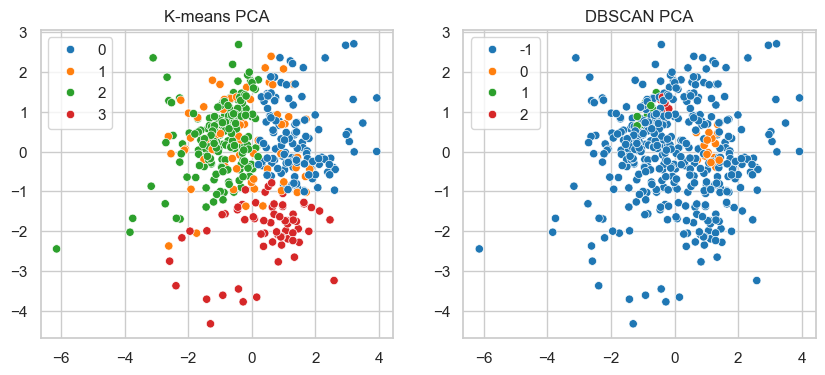


Reflection:
K-means assumes spherical clusters and equal variance.
DBSCAN finds arbitrary shapes but depends on eps/min_samples.
Use clusters to identify high TotalSpend customers for targeted marketing.


In [57]:
# Part F: Visualization & Reflection
pca=PCA(2).fit_transform(X_scaled)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); sns.scatterplot(x=pca[:,0],y=pca[:,1],hue=k_labels,palette='tab10'); plt.title('K-means PCA')
plt.subplot(1,2,2); sns.scatterplot(x=pca[:,0],y=pca[:,1],hue=db_labels,palette='tab10'); plt.title('DBSCAN PCA'); plt.show()

print('''\nReflection:\nK-means assumes spherical clusters and equal variance.\nDBSCAN finds arbitrary shapes but depends on eps/min_samples.\nUse clusters to identify high TotalSpend customers for targeted marketing.''')
